In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FCCY.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,7.981859,7.981859,7.981859,7.981859,7.603687,400
1,1/3/2013,7.981859,8.036282,7.981859,8.036282,7.655531,1300
2,1/4/2013,8.045351,8.235827,8.045351,8.217687,7.828341,500
3,1/7/2013,8.136054,8.244898,8.136054,8.235827,7.845623,900
4,1/8/2013,8.235827,8.235827,8.208617,8.208617,7.819701,1000


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 1025.143704.3, cost: 0.031028, total money: 7254.083692
epoch: 20, total rewards: 766.327855.3, cost: 0.016421, total money: 7999.857844
epoch: 30, total rewards: 585.105483.3, cost: 0.010294, total money: 8425.195476
epoch: 40, total rewards: 254.907860.3, cost: 0.005277, total money: 8908.577852
epoch: 50, total rewards: 175.498336.3, cost: 0.003558, total money: 9105.948327
epoch: 60, total rewards: 136.390713.3, cost: 0.002403, total money: 9329.790705
epoch: 70, total rewards: 134.771665.3, cost: 0.002302, total money: 9327.131658
epoch: 80, total rewards: 110.789756.3, cost: 0.001574, total money: 9504.479752
epoch: 90, total rewards: 115.565946.3, cost: 0.001001, total money: 9740.915944
epoch: 100, total rewards: 74.761655.3, cost: 0.000940, total money: 9775.471654
epoch: 110, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 8.571428, total balance 9991.428572
day 8, sell 1 unit at price 8.523809, investment -0.555553 %, total balance 9999.952381,
day 12: buy 1 unit at price 8.571428, total balance 9991.380953
day 13, sell 1 unit at price 8.571428, investment 0.000000 %, total balance 9999.952381,
day 14: buy 1 unit at price 8.571428, total balance 9991.380953
day 17, sell 1 unit at price 8.590476, investment 0.222224 %, total balance 9999.971429,
day 19: buy 1 unit at price 8.619047, total balance 9991.352382
day 20: buy 1 unit at price 8.571428, total balance 9982.780953
day 21, sell 1 unit at price 8.476191, investment -1.657452 %, total balance 9991.257144,
day 22, sell 1 unit at price 8.619047, investment 0.555553 %, total balance 9999.876191,
day 25: buy 1 unit at price 8.409524, total balance 9991.466667
day 26, sell 1 unit at price 8.428572, investment 0.226502 %, total balance 9999.895239,
day 27: buy 1 unit at price 8.514286, total balance 9991.380953
day 29, sell 1 uni

day 218: buy 1 unit at price 10.428572, total balance 9922.428570
day 220, sell 1 unit at price 10.209524, investment -0.924211 %, total balance 9932.638094,
day 221, sell 1 unit at price 10.209524, investment 4.995109 %, total balance 9942.847618,
day 223, sell 1 unit at price 9.523809, investment -1.960787 %, total balance 9952.371428,
day 224: buy 1 unit at price 9.523809, total balance 9942.847618
day 225: buy 1 unit at price 9.523809, total balance 9933.323809
day 226: buy 1 unit at price 9.523809, total balance 9923.799999
day 227, sell 1 unit at price 10.095238, investment 4.743083 %, total balance 9933.895237,
day 230, sell 1 unit at price 9.571428, investment -1.179948 %, total balance 9943.466665,
day 231: buy 1 unit at price 10.476191, total balance 9932.990475
day 233, sell 1 unit at price 10.714286, investment 7.965458 %, total balance 9943.704761,
day 234, sell 1 unit at price 10.476191, investment 4.662232 %, total balance 9954.180951,
day 237, sell 1 unit at price 10.54

day 390: buy 1 unit at price 9.666667, total balance 9995.247617
day 391: buy 1 unit at price 9.628572, total balance 9985.619045
day 392, sell 1 unit at price 9.714286, investment 0.492609 %, total balance 9995.333331,
day 394: buy 1 unit at price 9.761905, total balance 9985.571426
day 395, sell 1 unit at price 9.761905, investment 1.384766 %, total balance 9995.333331,
day 396, sell 1 unit at price 9.619047, investment -1.463419 %, total balance 10004.952378,
day 398: buy 1 unit at price 9.533334, total balance 9995.419044
day 399, sell 1 unit at price 9.533334, investment 0.000000 %, total balance 10004.952378,
day 402: buy 1 unit at price 9.676190, total balance 9995.276188
day 404, sell 1 unit at price 9.561905, investment -1.181100 %, total balance 10004.838093,
day 410: buy 1 unit at price 9.628572, total balance 9995.209521
day 411, sell 1 unit at price 9.619047, investment -0.098918 %, total balance 10004.828568,
day 414: buy 1 unit at price 9.714286, total balance 9995.11428

day 612: buy 1 unit at price 11.560000, total balance 9996.069525
day 613, sell 1 unit at price 11.650000, investment 0.778540 %, total balance 10007.719524,
day 614: buy 1 unit at price 11.980000, total balance 9995.739525
day 616: buy 1 unit at price 12.030000, total balance 9983.709525
day 617: buy 1 unit at price 12.850000, total balance 9970.859525
day 619, sell 1 unit at price 12.480000, investment 4.173623 %, total balance 9983.339524,
day 622: buy 1 unit at price 11.490000, total balance 9971.849525
day 623: buy 1 unit at price 11.610000, total balance 9960.239525
day 624: buy 1 unit at price 11.500000, total balance 9948.739525
day 629, sell 1 unit at price 11.500000, investment -4.405650 %, total balance 9960.239525,
day 630, sell 1 unit at price 11.500000, investment -10.505839 %, total balance 9971.739525,
day 633, sell 1 unit at price 11.360000, investment -1.131420 %, total balance 9983.099525,
day 634: buy 1 unit at price 11.510000, total balance 9971.589524
day 635, sel

day 807: buy 1 unit at price 12.180000, total balance 9919.069526
day 808, sell 1 unit at price 12.680000, investment 9.028377 %, total balance 9931.749526,
day 809: buy 1 unit at price 12.720000, total balance 9919.029526
day 810: buy 1 unit at price 12.750000, total balance 9906.279526
day 811, sell 1 unit at price 12.890000, investment 11.120689 %, total balance 9919.169526,
day 815, sell 1 unit at price 12.850000, investment 10.680454 %, total balance 9932.019526,
day 816: buy 1 unit at price 12.660000, total balance 9919.359527
day 817: buy 1 unit at price 12.570000, total balance 9906.789527
day 818, sell 1 unit at price 12.640000, investment -0.784925 %, total balance 9919.429527,
day 819: buy 1 unit at price 12.800000, total balance 9906.629527
day 821, sell 1 unit at price 12.780000, investment 0.629921 %, total balance 9919.409527,
day 824, sell 1 unit at price 12.400000, investment -4.247106 %, total balance 9931.809526,
day 826: buy 1 unit at price 12.410000, total balance 

day 998: buy 1 unit at price 16.850000, total balance 9947.029524
day 999: buy 1 unit at price 17.250000, total balance 9929.779524
day 1002, sell 1 unit at price 17.280001, investment 1.647063 %, total balance 9947.059524,
day 1003: buy 1 unit at price 17.350000, total balance 9929.709524
day 1004: buy 1 unit at price 18.100000, total balance 9911.609524
day 1005: buy 1 unit at price 18.250000, total balance 9893.359524
day 1006, sell 1 unit at price 18.000000, investment 6.194686 %, total balance 9911.359524,
day 1007, sell 1 unit at price 18.700001, investment 10.979230 %, total balance 9930.059524,
day 1010, sell 1 unit at price 18.650000, investment 10.682488 %, total balance 9948.709524,
day 1011, sell 1 unit at price 19.480000, investment 12.927534 %, total balance 9968.189524,
day 1014, sell 1 unit at price 19.900000, investment 14.697402 %, total balance 9988.089523,
day 1017: buy 1 unit at price 16.549999, total balance 9971.539524
day 1018: buy 1 unit at price 16.700001, tot

day 1192, sell 1 unit at price 18.500000, investment 7.871723 %, total balance 9876.709534,
day 1194, sell 1 unit at price 18.400000, investment 8.235292 %, total balance 9895.109533,
day 1195, sell 1 unit at price 18.150000, investment 7.079639 %, total balance 9913.259533,
day 1196: buy 1 unit at price 17.850000, total balance 9895.409532
day 1198: buy 1 unit at price 17.750000, total balance 9877.659532
day 1199: buy 1 unit at price 17.950001, total balance 9859.709532
day 1200: buy 1 unit at price 17.900000, total balance 9841.809532
day 1205, sell 1 unit at price 17.879999, investment 4.868035 %, total balance 9859.689531,
day 1206, sell 1 unit at price 17.900000, investment 3.170024 %, total balance 9877.589531,
day 1207, sell 1 unit at price 17.980000, investment 4.534876 %, total balance 9895.569530,
day 1209: buy 1 unit at price 17.950001, total balance 9877.619530
day 1211, sell 1 unit at price 17.950001, investment 3.160926 %, total balance 9895.569530,
day 1212, sell 1 unit

day 1410: buy 1 unit at price 21.950001, total balance 9956.269541
day 1411, sell 1 unit at price 21.900000, investment 2.576109 %, total balance 9978.169540,
day 1412: buy 1 unit at price 21.799999, total balance 9956.369541
day 1413, sell 1 unit at price 22.299999, investment 0.224716 %, total balance 9978.669540,
day 1414: buy 1 unit at price 22.450001, total balance 9956.219540
day 1416: buy 1 unit at price 22.350000, total balance 9933.869539
day 1419, sell 1 unit at price 21.900000, investment 0.458717 %, total balance 9955.769539,
day 1420, sell 1 unit at price 21.549999, investment -1.822330 %, total balance 9977.319538,
day 1421: buy 1 unit at price 21.650000, total balance 9955.669538
day 1422: buy 1 unit at price 21.500000, total balance 9934.169538
day 1423, sell 1 unit at price 21.500000, investment -1.376143 %, total balance 9955.669538,
day 1424, sell 1 unit at price 21.299999, investment -5.122501 %, total balance 9976.969538,
day 1428, sell 1 unit at price 21.100000, i

day 1611: buy 1 unit at price 18.770000, total balance 9905.699541
day 1612, sell 1 unit at price 18.950001, investment -2.117768 %, total balance 9924.649542,
day 1616, sell 1 unit at price 18.770000, investment -1.210524 %, total balance 9943.419542,
day 1617: buy 1 unit at price 18.930000, total balance 9924.489542
day 1619, sell 1 unit at price 18.799999, investment 0.320168 %, total balance 9943.289541,
day 1622: buy 1 unit at price 19.030001, total balance 9924.259540
day 1624, sell 1 unit at price 18.930000, investment 0.371154 %, total balance 9943.189541,
day 1626, sell 1 unit at price 18.799999, investment -0.053164 %, total balance 9961.989540,
day 1627: buy 1 unit at price 18.700001, total balance 9943.289539
day 1628: buy 1 unit at price 18.870001, total balance 9924.419538
day 1630: buy 1 unit at price 17.540001, total balance 9906.879537
day 1631: buy 1 unit at price 17.900000, total balance 9888.979538
day 1632: buy 1 unit at price 18.090000, total balance 9870.889538
d

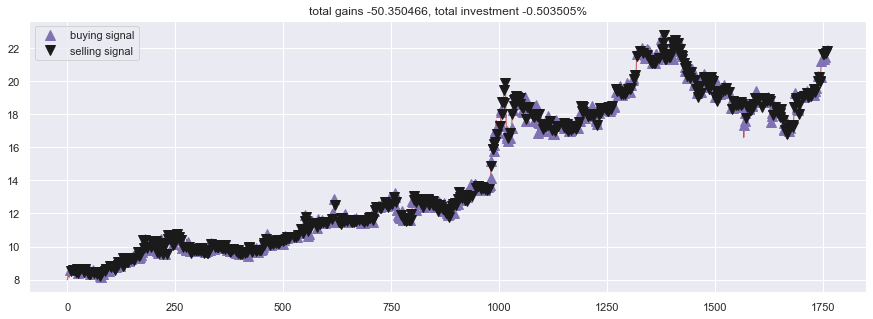

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()